<a href="https://colab.research.google.com/github/teoalcdor/tfg_teoalcdor/blob/main/ssd_300.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SSD300

Vamos a entrenar un modelo SSD300 en nuestro dataset de detección de objectos. Para ello, haremos uso del modelo pre-entrenado oficial de Pytorch, sustituiremos su cabeza para hacerla adecuada a el número de clases del modelo y, haciendo uso de transfer-learning, congelaremos la backbone, entrenando únicamente la nueva cabeza. Comenzamos importando e instalando las librerías necesarias:

## Librerías

In [ ]:
!pip install torchinfo
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [ ]:
import copy
import cv2
from google.colab import drive
import numpy as np
from math import inf
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision import models
from torchvision import transforms
from torchvision.models.detection.ssd import SSDHead
from torchvision.ops import nms
from torchmetrics.detection import MeanAveragePrecision
from tqdm import tqdm

In [ ]:
%matplotlib inline

Tratamos de utilizar la GPU:

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


## Funciones Auxiliares

Definimos las funciones que vamos a utilizar para el entrenamiento del modelo y la obtención y representación de resultados:

In [ ]:
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array([
    "Tank (TANK)",
    "Infantry fighting vehicle (IFV)",
    "Armored personnel carrier (APC)",
    "Engineering vehicle (EV)",
    "Assault helicopter (AH)",
    "Transport helicopter (TH)",
    "Assault airplane (AAP)",
    "Transport airplane (TA)",
    "Anti-aircraft vehicle (AA)",
    "Towed artillery (TART)",
    "Self-propelled artillery (SPART)",
    "Human"
])


def create_class_colors(num_classes, seed):
    """
    Crea un diccionario con los colores de cada clase elegidos de forma
    aleatoria.
    """

    # Reproducibilidad
    np.random.seed(seed)

    # Inicializacion
    class_colors = {}

    # Para cada clase, creamos su color
    for i in range(num_classes):

        # Mientras no aceptemos el color creado para la clase, seguimos creando
        # colores
        not_accepted = True
        while not_accepted:

            # Elegimos el valor para cada canal
            r = np.random.randint(0, 255)
            g = np.random.randint(0, 255)
            b = np.random.randint(0, 255)

            # El color no debe ser muy gris
            not_gray = abs(r - g) > 50 or abs(r - b) > 50 and abs(g - b) > 50

            # El color no debe ser muy blanco
            not_white = r < 230 and g < 230 and b < 230

            # Si no es muy gris ni muy blanco, lo aceptamos
            if not_gray and not_white :
                not_accepted = False
                class_colors[i] = (r, g, b)

    return class_colors

CLASS_COLORS = create_class_colors(12, 123)


def train_batch(inputs, model, optimizer):
    """
    Entrena el modelo en un batch.
    """

    model.train() # Modo entrenamiento

    # Obtenemos los pares imagen-anotacion como marca la documentacion
    input, targets = inputs
    input = list(image.to(DEVICE) for image in input)
    targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

    # Obtenemos la perdida
    losses = model(input, targets)
    loss = losses["classification"] + 1 * losses["bbox_regression"] # sum(loss for loss in losses.values())

    # Calculamos el gradiente de la perdida con retropropagacion
    loss.backward()

    # Hacemos un paso del metodo del gradiente
    optimizer.step()

    # Vaciamos el optimizador de la informacion del gradiente
    optimizer.zero_grad()

    return loss, losses


@torch.no_grad()
def validate_batch(inputs, model):
    """
    Calcula la accuracy del modelo en un batch.
    """

    model.train() # Modo entrenamiento

    # Obtenemos los pares imagen-anotacion como marca la documentacion
    input, targets = inputs
    input = list(image.to(DEVICE) for image in input)
    targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

    # Obtenemos la perdida
    losses = model(input, targets) # En modo entrenamiento devuelve un diccionario con las perdidas
    loss = losses["classification"] + 1 * losses["bbox_regression"] # sum(loss for loss in losses.values())

    return loss, losses


def train_model(model, optimizer, train_dataloader, val_dataloader, epochs=10):
    """
    Entrena el modelo, implementando un mecanismo que actúa como early stopping basado en
    la pérdida total en validación. Devuelve también las pérdidas encontradas en
    los conjuntos de entrenamiento y valiación durante el entrenamiento.
    """

    # Inicializamos las listas con las perdidas
    train_losses = []
    train_losses_classifier = []
    train_losses_box_reg = []
    val_losses = []
    val_losses_classifier = []
    val_losses_box_reg = []

    # Inicializamos el mecanismo de early stopping
    best_model = {
        "model_state_dict": None,
        "optimizer_state_dict": None,
        "epoch": None,
        "min_val_loss": inf
    }


    for epoch in range(epochs):
        # Regristramos el momento de comienzo de la epoch
        year, month, day, h, m, s = map(lambda x : x.rjust(2, "0"),
                                          time.strftime("%y %m %d %H %M %S")
                                          .split())
        time_stamp = f"{day}/{month}/{year} {h}:{m}:{s}"
        start = time.time()
        print("=" * 80)
        print(f"Epoch: {epoch + 1} - Started: {time_stamp}")

        # Inicializamos las listas con las perdidas y accuracies de la epoch
        train_epoch_losses = []
        train_epoch_losses_classifier = []
        train_epoch_losses_box_reg = []
        val_epoch_losses = []
        val_epoch_losses_classifier = []
        val_epoch_losses_box_reg = []

        # Entrenamos el modelo con minibatch
        _n = len(train_dataloader)
        for ix, inputs in tqdm(enumerate(train_dataloader), total=_n, desc="- Training"):
            loss, losses = train_batch(inputs, model, optimizer)
            loc_loss, regr_loss = \
                [losses[k] for k in ["bbox_regression", "classification"]]
            train_epoch_losses.append(loss.item())
            train_epoch_losses_classifier.append(loc_loss.item())
            train_epoch_losses_box_reg.append(regr_loss.item())

        # Calculamos las perdidas sobre el conjunto de validacion
        _n = len(val_dataloader)
        for ix, inputs in tqdm(enumerate(val_dataloader), total=_n, desc="- Validation"):
            loss, losses = validate_batch(inputs, model)
            loc_loss, regr_loss = \
                [losses[k] for k in ["bbox_regression", "classification"]]
            val_epoch_losses.append(loss.item())
            val_epoch_losses_classifier.append(loc_loss.item())
            val_epoch_losses_box_reg.append(regr_loss.item())

        # Actualizamos las perdidas y accuracies
        train_losses.append(np.mean(train_epoch_losses))
        train_losses_classifier.append(np.mean(train_epoch_losses_classifier))
        train_losses_box_reg.append(np.mean(train_epoch_losses_box_reg))
        val_losses.append(np.mean(val_epoch_losses))
        val_losses_classifier.append(np.mean(val_epoch_losses_classifier))
        val_losses_box_reg.append(np.mean(val_epoch_losses_box_reg))

        # Ponemos en marcha el mecanismo de early stopping
        if val_losses[-1] < best_model["min_val_loss"]:
            best_model["min_val_loss"] = val_losses[-1]
            best_model["model_state_dict"] = copy.deepcopy(model.state_dict())
            best_model["optimizer_state_dict"] = copy.deepcopy(optimizer.state_dict())
            best_model["epoch"] = epoch + 1

        # Regristramos el momento de comienzo de la epoch
        end = time.time()
        year, month, day, h, m, s = map(lambda x : x.rjust(2, "0"),
                                        time.strftime("%y %m %d %H %M %S")
                                        .split())
        time_stamp = f"{day}/{month}/{year} {h}:{m}:{s}"

        print(f"Epoch: {epoch + 1} - Ended: {time_stamp} - Duration: {round(end - start, 2)}s")
        print()

        # Imprimimos estadisticas de la epoch para un mejor seguimiento
        print(f"Training Loss: {train_losses[-1]} - Validation Loss: {val_losses[-1]}")
        print("=" * 80)
        print()

    return train_losses, train_losses_classifier, train_losses_box_reg, \
              val_losses, val_losses_classifier, val_losses_box_reg, best_model


def plot_training_results(train_losses, test_losses,
                          xlabel="Epochs", ylabel="Loss", title="Training Results"):
    """
    Representa la pérdida del modelo en el entrenamiento sobre los conjuntos de
    entrenamiento y validación.
    """

    # Diccionario con las perdidas
    losses = pd.DataFrame(
        {"train_losses": train_losses,
         "test_losses": test_losses})

    # Representacion grafica
    with sns.axes_style("whitegrid"):
        losses_plot = sns.lineplot(data=losses)
        losses_plot.set(
            xlabel=xlabel,
            ylabel=ylabel,
            title=title
        )
        plt.show()


def decode_output_ssd(output, conf_threshold=0.5):
    """
    Decodifica la salida de SSD300 para que sea posible representarla y
    calcular la mAP.
    """

    # Extraemos las partes de la salida
    bbs = output["boxes"].to("cpu").detach()
    labels = torch.tensor([i - 1 for i in output["labels"].to("cpu")])
    confs = output["scores"].to("cpu").detach()

    # Filtramos en las detecciones
    all_ixs = torch.arange(0, len(confs))
    ixs = torch.tensor([], dtype=torch.int32)

    for label in labels.unique():
        if label != 11:
            label_mask = labels == label # Seleccionamos las detecciones de una clase

            label_ixs = nms(bbs[label_mask], confs[label_mask], 0.05) # Hacemos Non-max suppression

            real_ixs = all_ixs[label_mask][label_ixs] # Seleccionamos solo las detecciones que pasan la nms

            final_ixs = real_ixs[confs[real_ixs] > 0.5] # Seleccionamos solo los indices con confianza > 0.5

            ixs = torch.cat((ixs, final_ixs)) # Nos quesamos con los indices de las detecciones de esta clase que pasan el filtro

    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]] # Filtramos las cajas, confianzas y etiquetas

    return bbs, confs, labels


def adapt_bbs(bbs, image):
    """
    Adapta las cajas de las detecciones de una imagen de formato 300x300 a las
    dimensiones de la imagen
    """
    real_w, real_h = image.shape[1], image.shape[0]
    bbs[:, 0:3:2] = bbs[:, 0:3:2] * real_w / 300
    bbs[:, 1:4:2] = bbs[:, 1:4:2] * real_h / 300

    return bbs


def plot_bbox(image, bbs, confs, labels, label_encoder=label_encoder,
              class_colors=CLASS_COLORS):
    """
    Dibuja unas detecciones a partir de la informacion de las cajas, confianzas
    y etiquetas.
    """

    for ix, bb in enumerate(bbs):

        # La etiqueta de la caja
        complete_label = \
            label_encoder.inverse_transform([labels[ix].item()])[0] + " - " +  \
            str(round(confs[ix].item(), 2))

        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.9
        font_thickness = 2
        text_size, _ = cv2.getTextSize(complete_label, font, font_scale, font_thickness)
        text_width, text_height = text_size

        # Tomamos medidas de la caja para centrar la etiqueta
        x0, y0, x1, y1 = bb
        x12 = (x0 + x1) / 2
        x2 = x12 - text_width / 2
        x3 = x12 + text_width / 2

        x0, y0 = int(x0), int(y0)
        x1, y1 = int(x1), int(y1)
        x2, x3 = int(x2), int(x3)

        # Pintamos caja y etiqueta
        bgr = class_colors[int(labels[ix].item())]
        image = cv2.rectangle(image, (x0, y0), (x1, y1), bgr, thickness=4)
        image = cv2.rectangle(image, (x2 - 20, y0), (x3 + 20, y0 - text_height - 20), bgr, -1)
        image = cv2.putText(image, complete_label, (x2, y0 - 10), font, 0.9, (255, 255, 255), 2)

    return image


@torch.no_grad()
def measure_fps_ssd(model, dataset, dataloader):
    """
    Estima los FPS a los que detecta SSD300. Se tiene el cuenta el
    post-procesamiento.
    """

    model.eval() # Modo evaluacion
    n = len(dataset)

    # Cronometramos cuanto tardamos en detectar y procesar las detecciones de
    # todas las imagenes
    torch.cuda.synchronize()
    start_time = time.time()

    for ix_dataloader, batch in enumerate(dataloader):
        for ix_batch, img in enumerate(batch[0]):
            image = dataset[ix_dataloader * 4 + ix_batch][0]
            output = model(img.unsqueeze(0))[0]
            output = decode_output_ssd(output)
            _ = adapt_bbs(output[0], image)

    torch.cuda.synchronize()
    total_time = time.time() - start_time

    # Calculamos los FPS
    fps = n / total_time
    print(f"FPS: {fps:.2f}")

    return fps


@torch.no_grad()
def calcula_map_ssd(model, dataset, dataloader, iou_list=[0.5]):
    """
    Calcula el mAP a distintos umbrales y su media para SSD300.
    """

    map_dict = {}
    model.eval()
    preds = []
    targets = []

    n = len(dataloader)

    # Hacemos las detecciones sobre las imagenes y las ponemos en una lista con
    # el formato de la documentacion de MeanAveragePrecision.
    for ix_dataloader, batch in tqdm(enumerate(dataloader), total = n):

      for ix_batch, img in enumerate(batch[0]):
        image = dataset[ix_dataloader * 4 + ix_batch][0]

        output = model(img.unsqueeze(0))[0]
        output = decode_output_ssd(output)

        bbs = adapt_bbs(output[0], image)
        preds.append({"boxes": bbs, "scores": output[1], "labels": output[2]})

        true_bbs = torch.tensor(dataset[ix_dataloader * 4 + ix_batch][1], dtype=torch.float32)
        true_labels = torch.tensor(dataset[ix_dataloader * 4 + ix_batch][2])
        targets.append({"boxes": true_bbs, "labels": true_labels})

    # Calculamos la mAP a distintos umbrales
    for iou in iou_list:
        metric = MeanAveragePrecision(iou_thresholds=[iou])
        metric.update(preds, targets)
        results = metric.compute()
        map_dict[f"map@{iou}"] = results
        print(f"mAP@{iou}: {results['map']:.4f}")

    # Calculamos la media si se da mas de un umbral
    if len(iou_list) > 1:
        metric = MeanAveragePrecision(iou_thresholds=list(iou_list))
        metric.update(preds, targets)
        results = metric.compute()
        map_dict["map"] = results["map"]
        print(f"Average mAP: {results['map']:.4f}")

    return map_dict

## Datos

Montamos nuestro Drive:

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


Leemos las anotaciones en formato PascalVOC:

In [ ]:
train_annotations = pd.read_csv("/content/drive/MyDrive/tfg/datasets/od_dataset_pv_train.csv")
val_annotations = pd.read_csv("/content/drive/MyDrive/tfg/datasets/od_dataset_pv_val.csv")
test_annotations = pd.read_csv("/content/drive/MyDrive/tfg/datasets/od_dataset_pv_test.csv")

In [ ]:
train_annotations_augmented = pd.read_csv("/content/drive/MyDrive/tfg/datasets/od_dataset_augmented_pv_train.csv")

In [ ]:
train_annotations_augmented_humans = pd.read_csv("/content/drive/MyDrive/tfg/datasets/od_dataset_augmented_humans_pv_train.csv")

Descomprimimos los datos:

In [ ]:
zip_path = "/content/drive/MyDrive/tfg/datasets/object_detection_dataset_yolo.zip"
extract_path = "/content/"
!unzip -q "$zip_path" -d "$extract_path"

Extraemos el dataset con las imágenes originales con anotaciones están corruptas:

In [ ]:
zip_path = "/content/drive/MyDrive/tfg/datasets/corrupt_object_detection_dataset.zip"
extract_path = "/content/"
!unzip -q "$zip_path" -d "$extract_path"

Extraemos el dataset con augmentations:

In [ ]:
zip_path = "/content/drive/MyDrive/tfg/datasets/object_detection_dataset_yolo_augmented.zip"
extract_path = "/content/"
!unzip -q "$zip_path" -d "$extract_path"

Extraemos el dataset con anotaciones corruptas de las fotos originales y las augmentations:

In [ ]:
zip_path = "/content/drive/MyDrive/tfg/datasets/corrupt_object_detection_dataset_augmented.zip"
extract_path = "/content/"
!unzip -q "$zip_path" -d "$extract_path"

Extraemos el dataset con augmentations e imágenes de personas:

In [ ]:
zip_path = "/content/drive/MyDrive/tfg/datasets/object_detection_dataset_yolo_augmented_humans.zip"
extract_path = "/content/"
!unzip -q "$zip_path" -d "$extract_path"

Almacenamos los nombres de las imágenes originales con anotationes corruptas en conjuntos:

In [ ]:
corrupt_train_images = set()
corrupt_val_images = set()
corrupt_test_images = set()

for image in os.listdir("/content/corrupt_object_detection_dataset/images/train/"):
    corrupt_train_images.add(image)
for image in os.listdir("/content/corrupt_object_detection_dataset/images/val/"):
    corrupt_val_images.add(image)
for image in os.listdir("/content/corrupt_object_detection_dataset/images/test/"):
    corrupt_test_images.add(image)


Almacenamos los nombres de las imágenes originales y con data augmentation con anotationes corruptas en conjuntos:

In [ ]:
corrupt_train_images_augmented = set()
corrupt_val_images_augmented = set()
corrupt_test_images_augmented = set()

for image in os.listdir("/content/corrupt_object_detection_dataset_augmented/images/train/"):
    corrupt_train_images_augmented.add(image)
for image in os.listdir("/content/corrupt_object_detection_dataset_augmented/images/val/"):
    corrupt_val_images_augmented.add(image)
for image in os.listdir("/content/corrupt_object_detection_dataset_augmented/images/test/"):
    corrupt_test_images_augmented.add(image)


Creamos la clase del dataset de detección de objetos:

In [ ]:
class ObjectDetectionDataset(Dataset):
    def __init__(self, annotations, images_path, w=300, h=300, corrupt=set(), transform=None):
        self.w = w
        self.h = h
        self.images_path = images_path
        self.annotations = annotations[~annotations["filename"].isin(corrupt)]
        self.images = self.annotations["filename"].unique()
        self.transform = transform
        self.basic_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((self.w, self.h)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, ix):
        image_id = self.images[ix]
        image_path = f"{self.images_path}/{image_id}"
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        data = self.annotations[self.annotations["filename"] == image_id]

        labels = data["class"].values

        data = data[["xmin", "ymin", "xmax", "ymax"]].values
        boxes = data.astype(np.uint32)

        return img, boxes, labels

    def collate_fn(self, batch):
        images, boxes, labels = tuple(zip(*batch))
        images_list = []
        targets_list = []
        for ix, image in enumerate(images):
            target = {}
            real_w, real_h = image.shape[1], image.shape[0]
            image = self.basic_transform(image)

            if self.transform:
                image = self.transform(image)

            images_list.append(image)

            boxes_array = boxes[ix]
            boxes_array[:, 0] = boxes_array[:, 0] * self.w / real_w
            boxes_array[:, 1] = boxes_array[:, 1] * self.h / real_h
            boxes_array[:, 2] = boxes_array[:, 2] * self.w / real_w
            boxes_array[:, 3] = boxes_array[:, 3] * self.h / real_h

            target["boxes"] = torch.Tensor(boxes_array).float().to(DEVICE)
            target["labels"] = torch.Tensor([label + 1 for label in labels[ix]]).long().to(DEVICE)

            targets_list.append(target)


        images = torch.stack(images_list).to(DEVICE)

        return images, targets_list

Instanciamos la clase para nuestros subconjuntos y creamos los dataloaders asociados:

In [ ]:
train_dataset = ObjectDetectionDataset(
    images_path="/content/object_detection_dataset_yolo/images/train/",
    annotations=train_annotations,
    corrupt=corrupt_train_images
)
train_dataloader = DataLoader(train_dataset, batch_size=16,
                              collate_fn=train_dataset.collate_fn,
                              shuffle=True)

val_dataset = ObjectDetectionDataset(
    images_path="/content/object_detection_dataset_yolo/images/val/",
    annotations=val_annotations,
    corrupt=corrupt_val_images
)
val_dataloader = DataLoader(val_dataset, batch_size=4,
                            collate_fn=val_dataset.collate_fn)

test_dataset = ObjectDetectionDataset(
    images_path="/content/object_detection_dataset_yolo/images/test/",
    annotations=test_annotations,
    corrupt=corrupt_test_images
)
test_dataloader = DataLoader(test_dataset, batch_size=4,
                             collate_fn=test_dataset.collate_fn)

train_dataset_augmented = ObjectDetectionDataset(
    images_path="/content/object_detection_dataset_yolo_augmented/images/train/",
    annotations=train_annotations_augmented,
    corrupt=corrupt_train_images_augmented
)
train_dataloader_augmented = DataLoader(train_dataset_augmented, batch_size=16,
                                        collate_fn=train_dataset.collate_fn,
                                        shuffle=True)


train_dataset_augmented_humans = ObjectDetectionDataset(
    images_path="/content/object_detection_dataset_yolo_augmented_humans/images/train/",
    annotations=train_annotations_augmented_humans,
    corrupt=corrupt_train_images_augmented
)
train_dataloader_augmented_humans = DataLoader(train_dataset_augmented_humans, batch_size=16,
                                               collate_fn=train_dataset.collate_fn,
                                               shuffle=True)

## Modelo

Comenzamos estudiando la estructura del modelo:

In [ ]:
model = models.detection.ssd300_vgg16(weights=models.detection.SSD300_VGG16_Weights.DEFAULT)
summary(model,  input_data=torch.rand(1, 3, 300, 300))

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:00<00:00, 201MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
SSD                                      [105, 4]                  --
├─GeneralizedRCNNTransform: 1-1          [1, 3, 300, 300]          --
├─SSDFeatureExtractorVGG: 1-2            [1, 256, 1, 1]            512
│    └─Sequential: 2-1                   [1, 512, 38, 38]          --
│    │    └─Conv2d: 3-1                  [1, 64, 300, 300]         (1,792)
│    │    └─ReLU: 3-2                    [1, 64, 300, 300]         --
│    │    └─Conv2d: 3-3                  [1, 64, 300, 300]         (36,928)
│    │    └─ReLU: 3-4                    [1, 64, 300, 300]         --
│    │    └─MaxPool2d: 3-5               [1, 64, 150, 150]         --
│    │    └─Conv2d: 3-6                  [1, 128, 150, 150]        73,856
│    │    └─ReLU: 3-7                    [1, 128, 150, 150]        --
│    │    └─Conv2d: 3-8                  [1, 128, 150, 150]        147,584
│    │    └─ReLU: 3-9                    [1, 128, 150, 150]     

Nos centramos en la estructura de la cabeza de clasficación, que es la parte que realmente vamos a adaptar y entrenar:

In [ ]:
model.head.classification_head

SSDClassificationHead(
  (module_list): ModuleList(
    (0): Conv2d(512, 364, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(1024, 546, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(512, 546, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(256, 546, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4-5): 2 x Conv2d(256, 364, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

Definimos una función que nos permita obtener nuestro modelo con todos los pesos cogelados salvo el de la cabeza de clasificación, que adaptamos a nuestro número de clases:

In [ ]:
def get_model(num_classes):
    """
    Nos permite obtener un modelo SSD300 listo para aplicar transfer learning
    (con su cabeza descongelada) y su optimizador (Adam).
    """

    # Obtenemos el modelo pre-entrenado
    model = models.detection.ssd300_vgg16(weights=models.detection.SSD300_VGG16_Weights.DEFAULT)

    # Congelamos todos los parametros de la backbone
    for param in model.backbone.parameters():
        param.requires_grad = False

    # Calculamos el numero de canales de entrada
    in_channels = \
    [layer.in_channels for layer in model.head.classification_head.module_list]

    # Calculamos el numero de cajas por clase (son 4 y 6, como en teoria)
    boxes_per_class_1 = 364 // 91
    boxes_per_class_2 = 546 // 91

    # Calculamos el numero de cajas por defecto
    num_anchors = [boxes_per_class_1] + \
      3 * [boxes_per_class_2] + \
      2 * [boxes_per_class_1]

    # Instanciamos un objeto de tipo SSDHead adaptado a nuestras necesidades que
    # usamos para hacer las detecciones
    model.head = SSDHead(
        in_channels=in_channels,
        num_anchors=num_anchors,
        num_classes=num_classes + 1
    )

    # Optimizador: Adam
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

    return model.to(DEVICE), optimizer

## Entrenamiento con los Datos Originales

In [ ]:
model, optimizer = get_model(num_classes=11)
summary(model, input_data=torch.rand(1, 3, 300, 300).to(DEVICE))

Layer (type:depth-idx)                   Output Shape              Param #
SSD                                      [200, 4]                  --
├─GeneralizedRCNNTransform: 1-1          [1, 3, 300, 300]          --
├─SSDFeatureExtractorVGG: 1-2            [1, 256, 1, 1]            512
│    └─Sequential: 2-1                   [1, 512, 38, 38]          --
│    │    └─Conv2d: 3-1                  [1, 64, 300, 300]         (1,792)
│    │    └─ReLU: 3-2                    [1, 64, 300, 300]         --
│    │    └─Conv2d: 3-3                  [1, 64, 300, 300]         (36,928)
│    │    └─ReLU: 3-4                    [1, 64, 300, 300]         --
│    │    └─MaxPool2d: 3-5               [1, 64, 150, 150]         --
│    │    └─Conv2d: 3-6                  [1, 128, 150, 150]        (73,856)
│    │    └─ReLU: 3-7                    [1, 128, 150, 150]        --
│    │    └─Conv2d: 3-8                  [1, 128, 150, 150]        (147,584)
│    │    └─ReLU: 3-9                    [1, 128, 150, 150] 

Vemos que, de 25,082,528 parámetros entrenables que teníamos, hemos pasado solo a 2,138,592. Entrenamos el modelo:

In [ ]:
train_losses, train_losses_classifier, train_losses_box_reg, \
    val_losses, val_losses_classifier, val_losses_box_reg, \
    best_model = \
    train_model(model, optimizer, train_dataloader, val_dataloader, epochs=20)

Epoch: 1 - Started: 23/03/25 22:51:57


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.81it/s]


Epoch: 1 - Ended: 23/03/25 22:57:03 - Duration: 306.09s

Training Loss: 6.153054486194127 - Validation Loss: 3.81478628713903

Epoch: 2 - Started: 23/03/25 22:57:03


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.89it/s]


Epoch: 2 - Ended: 23/03/25 23:02:00 - Duration: 297.68s

Training Loss: 3.2904448791288994 - Validation Loss: 3.036595161482509

Epoch: 3 - Started: 23/03/25 23:02:00


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.88it/s]


Epoch: 3 - Ended: 23/03/25 23:06:57 - Duration: 297.15s

Training Loss: 2.7469334612429983 - Validation Loss: 2.6762337646554673

Epoch: 4 - Started: 23/03/25 23:06:57


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.79it/s]


Epoch: 4 - Ended: 23/03/25 23:11:55 - Duration: 297.57s

Training Loss: 2.446727617189918 - Validation Loss: 2.4510746071028184

Epoch: 5 - Started: 23/03/25 23:11:55


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.91it/s]


Epoch: 5 - Ended: 23/03/25 23:16:53 - Duration: 298.3s

Training Loss: 2.2424712573978263 - Validation Loss: 2.290764770578108

Epoch: 6 - Started: 23/03/25 23:16:53


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.91it/s]


Epoch: 6 - Ended: 23/03/25 23:21:51 - Duration: 297.77s

Training Loss: 2.0898621930202967 - Validation Loss: 2.16715588938692

Epoch: 7 - Started: 23/03/25 23:21:51


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.87it/s]


Epoch: 7 - Ended: 23/03/25 23:26:49 - Duration: 297.44s

Training Loss: 1.9688295886550151 - Validation Loss: 2.0674766713629777

Epoch: 8 - Started: 23/03/25 23:26:49


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.71it/s]


Epoch: 8 - Ended: 23/03/25 23:31:47 - Duration: 298.0s

Training Loss: 1.8691107612260631 - Validation Loss: 1.9852606100590868

Epoch: 9 - Started: 23/03/25 23:31:47


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.73it/s]


Epoch: 9 - Ended: 23/03/25 23:36:46 - Duration: 299.53s

Training Loss: 1.7851045323089814 - Validation Loss: 1.915188511261483

Epoch: 10 - Started: 23/03/25 23:36:46


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.70it/s]


Epoch: 10 - Ended: 23/03/25 23:41:45 - Duration: 299.01s

Training Loss: 1.7129866162656058 - Validation Loss: 1.8554269489843664

Epoch: 11 - Started: 23/03/25 23:41:45


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.81it/s]


Epoch: 11 - Ended: 23/03/25 23:46:44 - Duration: 298.99s

Training Loss: 1.6504979551677972 - Validation Loss: 1.803489337828587

Epoch: 12 - Started: 23/03/25 23:46:44


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.79it/s]


Epoch: 12 - Ended: 23/03/25 23:51:42 - Duration: 297.97s

Training Loss: 1.5955206538589908 - Validation Loss: 1.7582433264730017

Epoch: 13 - Started: 23/03/25 23:51:42


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.71it/s]


Epoch: 13 - Ended: 23/03/25 23:56:40 - Duration: 298.41s

Training Loss: 1.5468208701677726 - Validation Loss: 1.718066674192649

Epoch: 14 - Started: 23/03/25 23:56:40


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.68it/s]


Epoch: 14 - Ended: 24/03/25 00:01:39 - Duration: 298.81s

Training Loss: 1.503134293035722 - Validation Loss: 1.6819189564308898

Epoch: 15 - Started: 24/03/25 00:01:39


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.67it/s]


Epoch: 15 - Ended: 24/03/25 00:06:38 - Duration: 298.46s

Training Loss: 1.4636189208903783 - Validation Loss: 1.6490957181928199

Epoch: 16 - Started: 24/03/25 00:06:38


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.79it/s]


Epoch: 16 - Ended: 24/03/25 00:11:36 - Duration: 298.19s

Training Loss: 1.4277543069611134 - Validation Loss: 1.6197587055421871

Epoch: 17 - Started: 24/03/25 00:11:36


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.75it/s]


Epoch: 17 - Ended: 24/03/25 00:16:34 - Duration: 297.99s

Training Loss: 1.394898969858465 - Validation Loss: 1.5927304003103946

Epoch: 18 - Started: 24/03/25 00:16:34


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.75it/s]


Epoch: 18 - Ended: 24/03/25 00:21:32 - Duration: 298.22s

Training Loss: 1.364664581292112 - Validation Loss: 1.5678523714477952

Epoch: 19 - Started: 24/03/25 00:21:32


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.82it/s]


Epoch: 19 - Ended: 24/03/25 00:26:30 - Duration: 297.8s

Training Loss: 1.3367539561970134 - Validation Loss: 1.545139243327429

Epoch: 20 - Started: 24/03/25 00:26:30


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.76it/s]

Epoch: 20 - Ended: 24/03/25 00:31:28 - Duration: 298.31s

Training Loss: 1.3108389527025357 - Validation Loss: 1.5246471967685427



Salvamos un checkpoint del modelo para volver a él si fuera necesario:

In [ ]:
torch.save({
            "epoch": 20,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": train_losses[-1],
            "train_losses": train_losses,
            "train_losses_classifier": train_losses_classifier,
            "train_losses_box_reg": train_losses_box_reg,
            "val_losses": val_losses,
            "val_losses_classifier": val_losses_classifier,
            "val_losses_box_reg": val_losses_box_reg,
            "best_model": best_model
            }, "/content/drive/MyDrive/tfg/models/ssd300.pth")

### Resultados

In [ ]:
checkpoint = torch.load("/content/drive/MyDrive/tfg/models/ssd300.pth", weights_only=False)
model, _ = get_model(num_classes=11)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [ ]:
train_losses = checkpoint["train_losses"]
train_losses_classifier = checkpoint["train_losses_classifier"]
train_losses_box_reg = checkpoint["train_losses_box_reg"]
val_losses = checkpoint["val_losses"]
val_losses_classifier = checkpoint["val_losses_classifier"]
val_losses_box_reg = checkpoint["val_losses_box_reg"]

#### Pérdidas

Representamos la evolución de las distintas pérdidas del modelo durante el entrenamiento:

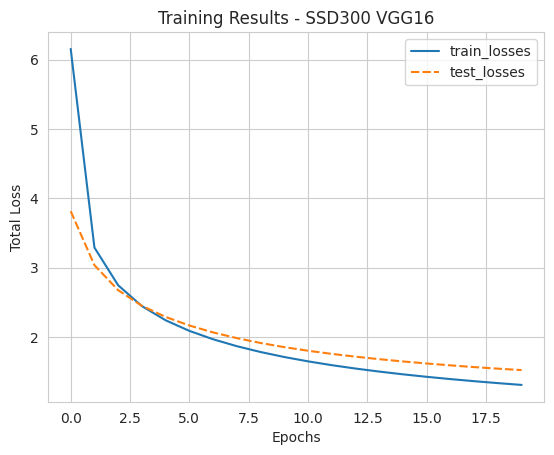

In [ ]:
plot_training_results(train_losses, val_losses,
                      "Epochs", "Total Loss", "Training Results - SSD300 VGG16")

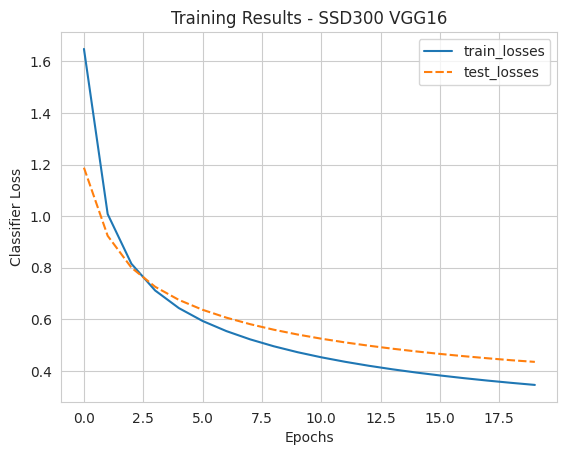

In [ ]:
plot_training_results(train_losses_classifier, val_losses_classifier,
                      "Epochs", "Classifier Loss", "Training Results - SSD300 VGG16")

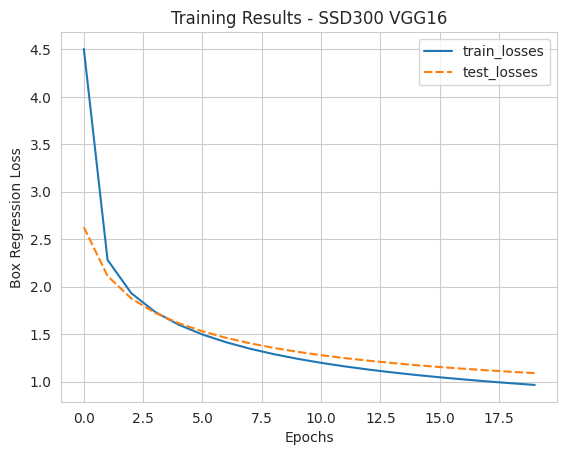

In [ ]:
plot_training_results(train_losses_box_reg, val_losses_box_reg,
                      "Epochs", "Box Regression Loss", "Training Results - SSD300 VGG16")

#### Métricas

In [ ]:
_ = measure_fps_ssd(model, val_dataset, val_dataloader)

FPS: 28.78


In [ ]:
map = calcula_map_ssd(model, val_dataset, val_dataloader, iou_list=np.round(np.linspace(0.5, 0.95, 10), 2))

100%|██████████| 407/407 [01:20<00:00,  5.09it/s]


mAP@0.5: 0.6769
mAP@0.55: 0.6676
mAP@0.6: 0.6529
mAP@0.65: 0.6343
mAP@0.7: 0.6031
mAP@0.75: 0.5537
mAP@0.8: 0.4624
mAP@0.85: 0.3093
mAP@0.9: 0.1007
mAP@0.95: 0.0054
Average mAP: 0.4666


#### Pruebas sobre Imágenes

[5]


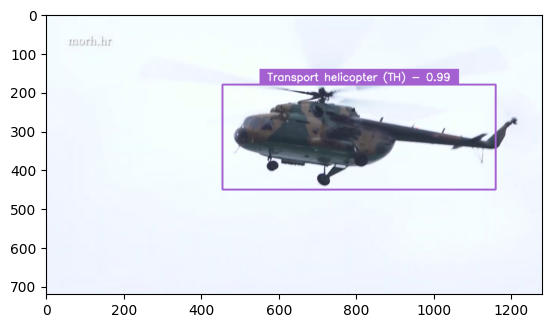

In [ ]:
observation = val_dataset[1301]
image = observation[0]
boxes = observation[1]
labels = observation[2]
print(labels)
img, targets = val_dataset.collate_fn([observation])
model.eval()
output = model(img[0].unsqueeze(0).to(DEVICE))[0]
bbs, confs, labels = decode_output_ssd(output)
bbs = adapt_bbs(bbs, image)
image_rect = plot_bbox(image, bbs, confs, labels)
plt.imshow(image_rect)

## Entrenamiento con los Datos con Data Augmentation

In [ ]:
model, optimizer = get_model(num_classes=11)
summary(model, input_data=torch.rand(1, 3, 300, 300).to(DEVICE))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
SSD                                      [200, 4]                  --
├─GeneralizedRCNNTransform: 1-1          [1, 3, 300, 300]          --
├─SSDFeatureExtractorVGG: 1-2            [1, 256, 1, 1]            512
│    └─Sequential: 2-1                   [1, 512, 38, 38]          --
│    │    └─Conv2d: 3-1                  [1, 64, 300, 300]         (1,792)
│    │    └─ReLU: 3-2                    [1, 64, 300, 300]         --
│    │    └─Conv2d: 3-3                  [1, 64, 300, 300]         (36,928)
│    │    └─ReLU: 3-4                    [1, 64, 300, 300]         --
│    │    └─MaxPool2d: 3-5               [1, 64, 150, 150]         --
│    │    └─Conv2d: 3-6                  [1, 128, 150, 150]        (73,856)
│    │    └─ReLU: 3-7                    [1, 128, 150, 150]        --
│    │    └─Conv2d: 3-8                  [1, 128, 150, 150]        (147,584)
│    │    └─ReLU: 3-9                    [1, 128, 150, 150] 

Vemos que, de 25,082,528 parámetros entrenables que teníamos, hemos pasado solo a 2,138,592. Entrenamos el modelo:

In [ ]:
train_losses, train_losses_classifier, train_losses_box_reg, \
    val_losses, val_losses_classifier, val_losses_box_reg, \
    best_model = \
    train_model(model, optimizer, train_dataloader_augmented, val_dataloader, epochs=20)

Epoch: 1 - Started: 24/03/25 00:31:37


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.76it/s]


Epoch: 1 - Ended: 24/03/25 00:41:55 - Duration: 618.11s

Training Loss: 5.293445554562569 - Validation Loss: 3.3293384987247663

Epoch: 2 - Started: 24/03/25 00:41:55


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.74it/s]


Epoch: 2 - Ended: 24/03/25 00:52:12 - Duration: 616.22s

Training Loss: 3.315897250024259 - Validation Loss: 2.7562796023905425

Epoch: 3 - Started: 24/03/25 00:52:12


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.71it/s]


Epoch: 3 - Ended: 24/03/25 01:02:28 - Duration: 616.13s

Training Loss: 2.908606069956639 - Validation Loss: 2.4718806617675892

Epoch: 4 - Started: 24/03/25 01:02:28


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.67it/s]


Epoch: 4 - Ended: 24/03/25 01:12:45 - Duration: 616.71s

Training Loss: 2.6694593936141904 - Validation Loss: 2.2902779482506417

Epoch: 5 - Started: 24/03/25 01:12:45


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.66it/s]


Epoch: 5 - Ended: 24/03/25 01:23:01 - Duration: 616.61s

Training Loss: 2.5030999732235943 - Validation Loss: 2.15796272423695

Epoch: 6 - Started: 24/03/25 01:23:01


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.71it/s]


Epoch: 6 - Ended: 24/03/25 01:33:17 - Duration: 616.05s

Training Loss: 2.3772950856260553 - Validation Loss: 2.058091520530879

Epoch: 7 - Started: 24/03/25 01:33:17


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.67it/s]


Epoch: 7 - Ended: 24/03/25 01:43:34 - Duration: 616.59s

Training Loss: 2.2774553893736504 - Validation Loss: 1.9786274622054885

Epoch: 8 - Started: 24/03/25 01:43:34


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.77it/s]


Epoch: 8 - Ended: 24/03/25 01:53:50 - Duration: 616.47s

Training Loss: 2.195505611488229 - Validation Loss: 1.9132358718855669

Epoch: 9 - Started: 24/03/25 01:53:50


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.76it/s]


Epoch: 9 - Ended: 24/03/25 02:04:07 - Duration: 616.76s

Training Loss: 2.1263830043464753 - Validation Loss: 1.8588109104287711

Epoch: 10 - Started: 24/03/25 02:04:07


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.80it/s]


Epoch: 10 - Ended: 24/03/25 02:14:23 - Duration: 616.03s

Training Loss: 2.066960164910895 - Validation Loss: 1.8117521195798307

Epoch: 11 - Started: 24/03/25 02:14:23


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.73it/s]


Epoch: 11 - Ended: 24/03/25 02:24:39 - Duration: 615.67s

Training Loss: 2.0149541369956343 - Validation Loss: 1.7714562830526648

Epoch: 12 - Started: 24/03/25 02:24:39


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.72it/s]


Epoch: 12 - Ended: 24/03/25 02:34:54 - Duration: 615.75s

Training Loss: 1.968941042421568 - Validation Loss: 1.736276663052655

Epoch: 13 - Started: 24/03/25 02:34:54


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.78it/s]


Epoch: 13 - Ended: 24/03/25 02:45:11 - Duration: 616.42s

Training Loss: 1.927681765731075 - Validation Loss: 1.7049324417289997

Epoch: 14 - Started: 24/03/25 02:45:11


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.72it/s]


Epoch: 14 - Ended: 24/03/25 02:55:27 - Duration: 616.27s

Training Loss: 1.8903941305024763 - Validation Loss: 1.677046610916569

Epoch: 15 - Started: 24/03/25 02:55:27


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.77it/s]


Epoch: 15 - Ended: 24/03/25 03:05:44 - Duration: 616.65s

Training Loss: 1.8564959469607718 - Validation Loss: 1.6518431524093966

Epoch: 16 - Started: 24/03/25 03:05:44


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.83it/s]


Epoch: 16 - Ended: 24/03/25 03:16:00 - Duration: 616.12s

Training Loss: 1.8253215820206312 - Validation Loss: 1.629078773667244

Epoch: 17 - Started: 24/03/25 03:16:00


- Validation: 100%|██████████| 407/407 [00:35<00:00, 11.57it/s]


Epoch: 17 - Ended: 24/03/25 03:26:17 - Duration: 617.48s

Training Loss: 1.79662733186375 - Validation Loss: 1.6079784448668177

Epoch: 18 - Started: 24/03/25 03:26:17


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.79it/s]


Epoch: 18 - Ended: 24/03/25 03:36:34 - Duration: 616.56s

Training Loss: 1.7700230227632368 - Validation Loss: 1.5886711339107016

Epoch: 19 - Started: 24/03/25 03:36:34


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.70it/s]


Epoch: 19 - Ended: 24/03/25 03:46:51 - Duration: 616.96s

Training Loss: 1.7453968455625135 - Validation Loss: 1.5711391850830003

Epoch: 20 - Started: 24/03/25 03:46:51


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.78it/s]

Epoch: 20 - Ended: 24/03/25 03:57:07 - Duration: 616.21s

Training Loss: 1.7222362624414376 - Validation Loss: 1.554451209174913



Salvamos un checkpoint del modelo para volver a él si fuera necesario:

In [ ]:
torch.save({
            "epoch": 20,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": train_losses[-1],
            "train_losses": train_losses,
            "train_losses_classifier": train_losses_classifier,
            "train_losses_box_reg": train_losses_box_reg,
            "val_losses": val_losses,
            "val_losses_classifier": val_losses_classifier,
            "val_losses_box_reg": val_losses_box_reg,
            "best_model": best_model
            }, "/content/drive/MyDrive/tfg/models/ssd300_augmented.pth")

### Resultados

In [ ]:
checkpoint = torch.load("/content/drive/MyDrive/tfg/models/ssd300_augmented.pth", weights_only=False)
model, _ = get_model(num_classes=11)
model.load_state_dict(checkpoint["best_model"]["model_state_dict"])

<All keys matched successfully>

In [ ]:
train_losses = checkpoint["train_losses"]
train_losses_classifier = checkpoint["train_losses_classifier"]
train_losses_box_reg = checkpoint["train_losses_box_reg"]
val_losses = checkpoint["val_losses"]
val_losses_classifier = checkpoint["val_losses_classifier"]
val_losses_box_reg = checkpoint["val_losses_box_reg"]

#### Pérdidas

Representamos la evolución de las distintas pérdidas del modelo durante el entrenamiento:

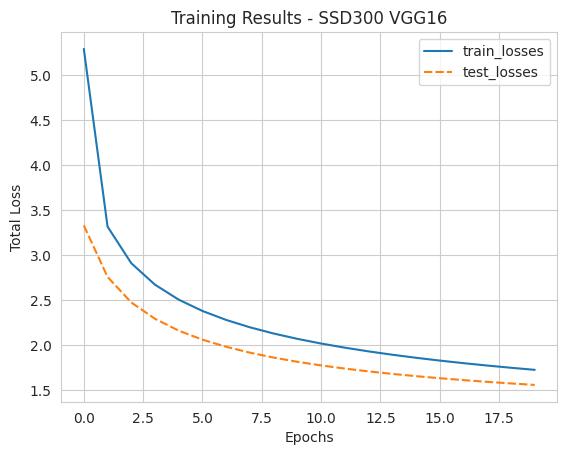

In [ ]:
plot_training_results(train_losses, val_losses,
                      "Epochs", "Total Loss", "Training Results - SSD300 VGG16")

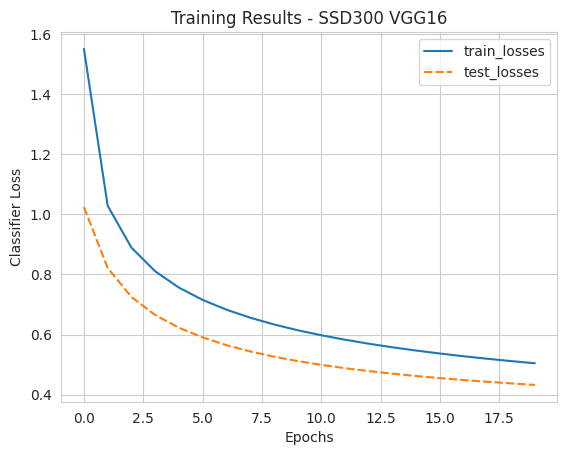

In [ ]:
plot_training_results(train_losses_classifier, val_losses_classifier,
                      "Epochs", "Classifier Loss", "Training Results - SSD300 VGG16")

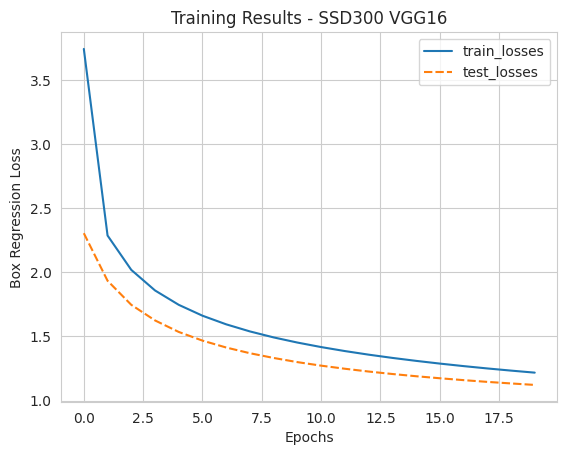

In [ ]:
plot_training_results(train_losses_box_reg, val_losses_box_reg,
                      "Epochs", "Box Regression Loss", "Training Results - SSD300 VGG16")

#### Métricas

In [ ]:
_ = measure_fps_ssd(model, val_dataset, val_dataloader)

FPS: 27.34


In [ ]:
_ = calcula_map_ssd(model, val_dataset, val_dataloader, iou_list=np.round(np.linspace(0.5, 0.95, 10), 2))

100%|██████████| 407/407 [01:23<00:00,  4.88it/s]


mAP@0.5: 0.6767
mAP@0.55: 0.6687
mAP@0.6: 0.6587
mAP@0.65: 0.6399
mAP@0.7: 0.6091
mAP@0.75: 0.5480
mAP@0.8: 0.4639
mAP@0.85: 0.3151
mAP@0.9: 0.1069
mAP@0.95: 0.0048
Average mAP: 0.4692


#### Pruebas sobre Imágenes

[7]
tensor([7])


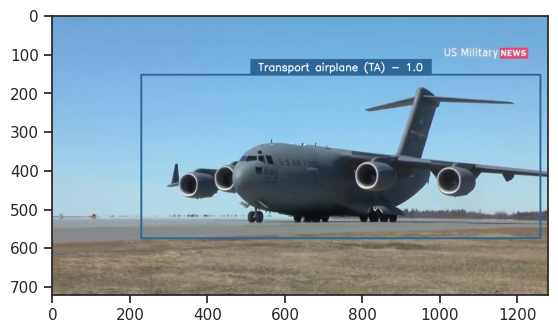

In [ ]:
observation = val_dataset[1300]
image = observation[0]
boxes = observation[1]
labels = observation[2]
print(labels)
img, targets = val_dataset.collate_fn([observation])
model.eval()
output = model(img[0].unsqueeze(0).to(DEVICE))[0]
bbs, confs, labels = decode_output_ssd(output)
print(labels)
bbs = adapt_bbs(bbs, image)
image_rect = plot_bbox(image, bbs, confs, labels)
plt.imshow(image_rect)

## Entrenamiento con los Datos con Data Augmentation e Imágenes de Personas

In [ ]:
model, optimizer = get_model(num_classes=12)
summary(model, input_data=torch.rand(1, 3, 300, 300).to(DEVICE))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
SSD                                      [200, 4]                  --
├─GeneralizedRCNNTransform: 1-1          [1, 3, 300, 300]          --
├─SSDFeatureExtractorVGG: 1-2            [1, 256, 1, 1]            512
│    └─Sequential: 2-1                   [1, 512, 38, 38]          --
│    │    └─Conv2d: 3-1                  [1, 64, 300, 300]         (1,792)
│    │    └─ReLU: 3-2                    [1, 64, 300, 300]         --
│    │    └─Conv2d: 3-3                  [1, 64, 300, 300]         (36,928)
│    │    └─ReLU: 3-4                    [1, 64, 300, 300]         --
│    │    └─MaxPool2d: 3-5               [1, 64, 150, 150]         --
│    │    └─Conv2d: 3-6                  [1, 128, 150, 150]        (73,856)
│    │    └─ReLU: 3-7                    [1, 128, 150, 150]        --
│    │    └─Conv2d: 3-8                  [1, 128, 150, 150]        (147,584)
│    │    └─ReLU: 3-9                    [1, 128, 150, 150] 

Vemos que, de 25,082,528 parámetros entrenables que teníamos, hemos pasado solo a 2,138,592. Entrenamos el modelo:

In [ ]:
train_losses, train_losses_classifier, train_losses_box_reg, \
    val_losses, val_losses_classifier, val_losses_box_reg, \
    best_model = \
    train_model(model, optimizer, train_dataloader_augmented_humans, val_dataloader, epochs=20)

Epoch: 1 - Started: 25/03/25 19:00:12


- Validation: 100%|██████████| 407/407 [00:36<00:00, 11.09it/s]


Epoch: 1 - Ended: 25/03/25 19:11:22 - Duration: 670.44s

Training Loss: 5.456452098051707 - Validation Loss: 3.347601968767602

Epoch: 2 - Started: 25/03/25 19:11:22


- Validation: 100%|██████████| 407/407 [00:35<00:00, 11.54it/s]


Epoch: 2 - Ended: 25/03/25 19:22:32 - Duration: 669.46s

Training Loss: 3.4689189014434816 - Validation Loss: 2.7794560853034915

Epoch: 3 - Started: 25/03/25 19:22:32


- Validation: 100%|██████████| 407/407 [00:35<00:00, 11.51it/s]


Epoch: 3 - Ended: 25/03/25 19:33:39 - Duration: 667.96s

Training Loss: 3.063812745253245 - Validation Loss: 2.4939860093798627

Epoch: 4 - Started: 25/03/25 19:33:39


- Validation: 100%|██████████| 407/407 [00:35<00:00, 11.52it/s]


Epoch: 4 - Ended: 25/03/25 19:44:47 - Duration: 667.92s

Training Loss: 2.826733216047287 - Validation Loss: 2.309635751809769

Epoch: 5 - Started: 25/03/25 19:44:47


- Validation: 100%|██████████| 407/407 [00:35<00:00, 11.56it/s]


Epoch: 5 - Ended: 25/03/25 19:55:55 - Duration: 667.83s

Training Loss: 2.6615708870887755 - Validation Loss: 2.1777680078361192

Epoch: 6 - Started: 25/03/25 19:55:55


- Validation: 100%|██████████| 407/407 [00:35<00:00, 11.54it/s]


Epoch: 6 - Ended: 25/03/25 20:07:04 - Duration: 668.31s

Training Loss: 2.536500015974045 - Validation Loss: 2.078025045793238

Epoch: 7 - Started: 25/03/25 20:07:04


- Validation: 100%|██████████| 407/407 [00:34<00:00, 11.65it/s]


Epoch: 7 - Ended: 25/03/25 20:18:11 - Duration: 667.93s

Training Loss: 2.436945240577062 - Validation Loss: 1.9980352869490734

Epoch: 8 - Started: 25/03/25 20:18:11


- Validation: 100%|██████████| 407/407 [00:35<00:00, 11.60it/s]


Epoch: 8 - Ended: 25/03/25 20:29:20 - Duration: 668.52s

Training Loss: 2.355091875632604 - Validation Loss: 1.9335549315597853

Epoch: 9 - Started: 25/03/25 20:29:20


- Validation: 100%|██████████| 407/407 [00:35<00:00, 11.62it/s]


Epoch: 9 - Ended: 25/03/25 20:40:28 - Duration: 668.41s

Training Loss: 2.285809857447942 - Validation Loss: 1.8793437360838532

Epoch: 10 - Started: 25/03/25 20:40:28


- Validation: 100%|██████████| 407/407 [00:35<00:00, 11.60it/s]


Epoch: 10 - Ended: 25/03/25 20:51:36 - Duration: 667.19s

Training Loss: 2.2260389187335967 - Validation Loss: 1.8331777872265995

Epoch: 11 - Started: 25/03/25 20:51:36


- Validation: 100%|██████████| 407/407 [00:35<00:00, 11.58it/s]


Epoch: 11 - Ended: 25/03/25 21:02:44 - Duration: 668.75s

Training Loss: 2.1738177088101707 - Validation Loss: 1.7932121446150233

Epoch: 12 - Started: 25/03/25 21:02:44


- Validation: 100%|██████████| 407/407 [00:35<00:00, 11.59it/s]


Epoch: 12 - Ended: 25/03/25 21:13:54 - Duration: 669.78s

Training Loss: 2.127344668785731 - Validation Loss: 1.7578634657789507

Epoch: 13 - Started: 25/03/25 21:13:54


- Validation: 100%|██████████| 407/407 [00:35<00:00, 11.51it/s]


Epoch: 13 - Ended: 25/03/25 21:25:03 - Duration: 668.49s

Training Loss: 2.085642370223999 - Validation Loss: 1.7266790551986975

Epoch: 14 - Started: 25/03/25 21:25:03


- Validation: 100%|██████████| 407/407 [00:35<00:00, 11.60it/s]


Epoch: 14 - Ended: 25/03/25 21:36:10 - Duration: 667.46s

Training Loss: 2.0478757879734037 - Validation Loss: 1.6984622354003662

Epoch: 15 - Started: 25/03/25 21:36:10


- Validation: 100%|██████████| 407/407 [00:35<00:00, 11.56it/s]


Epoch: 15 - Ended: 25/03/25 21:47:17 - Duration: 666.48s

Training Loss: 2.0134933116436007 - Validation Loss: 1.673529251055284

Epoch: 16 - Started: 25/03/25 21:47:17


- Validation: 100%|██████████| 407/407 [00:35<00:00, 11.61it/s]


Epoch: 16 - Ended: 25/03/25 21:58:23 - Duration: 666.87s

Training Loss: 1.981873569170634 - Validation Loss: 1.6505314228136359

Epoch: 17 - Started: 25/03/25 21:58:23


- Validation: 100%|██████████| 407/407 [00:35<00:00, 11.57it/s]


Epoch: 17 - Ended: 25/03/25 22:09:31 - Duration: 668.05s

Training Loss: 1.9526982576847076 - Validation Loss: 1.6295657215012964

Epoch: 18 - Started: 25/03/25 22:09:31


- Validation: 100%|██████████| 407/407 [00:35<00:00, 11.54it/s]


Epoch: 18 - Ended: 25/03/25 22:20:41 - Duration: 669.71s

Training Loss: 1.9255475992361704 - Validation Loss: 1.6104687508699056

Epoch: 19 - Started: 25/03/25 22:20:41


- Validation: 100%|██████████| 407/407 [00:35<00:00, 11.56it/s]


Epoch: 19 - Ended: 25/03/25 22:31:51 - Duration: 669.99s

Training Loss: 1.9002805779774983 - Validation Loss: 1.592391633943492

Epoch: 20 - Started: 25/03/25 22:31:51


- Validation: 100%|██████████| 407/407 [00:35<00:00, 11.61it/s]

Epoch: 20 - Ended: 25/03/25 22:43:00 - Duration: 668.57s

Training Loss: 1.8766866731643677 - Validation Loss: 1.5759060445815984



Salvamos un checkpoint del modelo para volver a él si fuera necesario:

In [ ]:
torch.save({
            "epoch": 20,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": train_losses[-1],
            "train_losses": train_losses,
            "train_losses_classifier": train_losses_classifier,
            "train_losses_box_reg": train_losses_box_reg,
            "val_losses": val_losses,
            "val_losses_classifier": val_losses_classifier,
            "val_losses_box_reg": val_losses_box_reg,
            "best_model": best_model
            }, "/content/drive/MyDrive/tfg/models/ssd300_augmented_humans.pth")

### Resultados

In [ ]:
checkpoint = torch.load("/content/drive/MyDrive/tfg/models/ssd300_augmented_humans.pth", weights_only=False)
model, _ = get_model(num_classes=11)
model.load_state_dict(checkpoint["best_model"]["model_state_dict"])

<All keys matched successfully>

In [ ]:
train_losses = checkpoint["train_losses"]
train_losses_classifier = checkpoint["train_losses_classifier"]
train_losses_box_reg = checkpoint["train_losses_box_reg"]
val_losses = checkpoint["val_losses"]
val_losses_classifier = checkpoint["val_losses_classifier"]
val_losses_box_reg = checkpoint["val_losses_box_reg"]

#### Pérdidas

Representamos la evolución de las distintas pérdidas del modelo durante el entrenamiento:

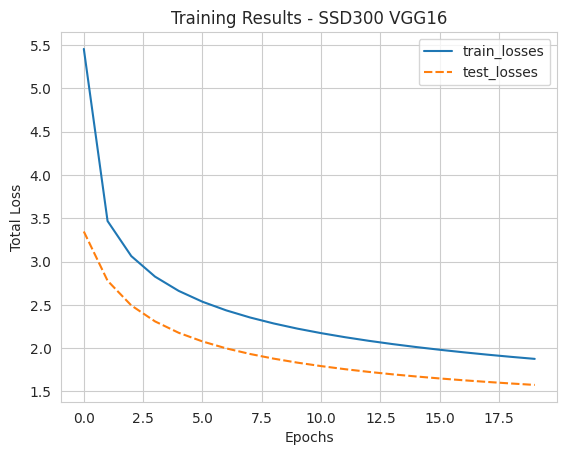

In [ ]:
plot_training_results(train_losses, val_losses,
                      "Epochs", "Total Loss", "Training Results - SSD300 VGG16")

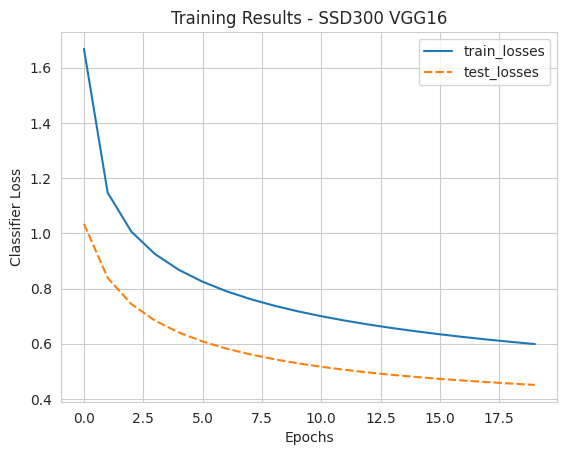

In [ ]:
plot_training_results(train_losses_classifier, val_losses_classifier,
                      "Epochs", "Classifier Loss", "Training Results - SSD300 VGG16")

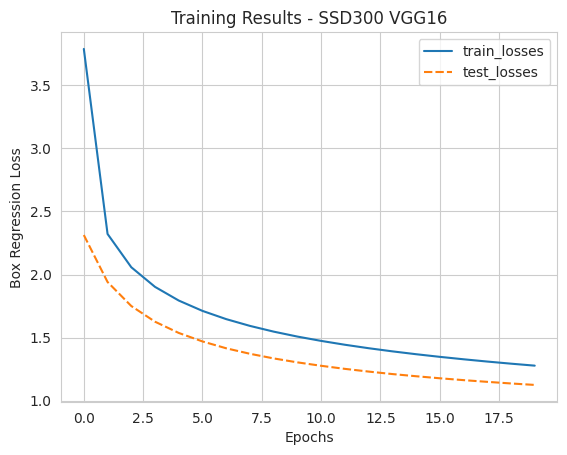

In [ ]:
plot_training_results(train_losses_box_reg, val_losses_box_reg,
                      "Epochs", "Box Regression Loss", "Training Results - SSD300 VGG16")

#### Métricas

In [ ]:
_ = measure_fps_ssd(model, val_dataset, val_dataloader)

FPS: 26.99


In [ ]:
_ = calcula_map_ssd(model, val_dataset, val_dataloader, iou_list=np.round(np.linspace(0.5, 0.95, 10), 2))

100%|██████████| 407/407 [01:25<00:00,  4.78it/s]


mAP@0.5: 0.6768
mAP@0.55: 0.6693
mAP@0.6: 0.6540
mAP@0.65: 0.6351
mAP@0.7: 0.6015
mAP@0.75: 0.5515
mAP@0.8: 0.4628
mAP@0.85: 0.3111
mAP@0.9: 0.0983
mAP@0.95: 0.0060
Average mAP: 0.4666


#### Pruebas sobre Imágenes

[3]
tensor([3])


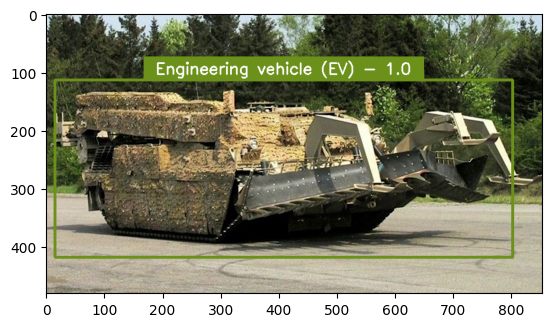

In [ ]:
observation = val_dataset[54]
image = observation[0]
boxes = observation[1]
labels = observation[2]
print(labels)
img, targets = val_dataset.collate_fn([observation])
model.eval()
output = model(img[0].unsqueeze(0).to(DEVICE))[0]
bbs, confs, labels = decode_output_ssd(output)
print(labels)
bbs = adapt_bbs(bbs, image)
image_rect = plot_bbox(image, bbs, confs, labels)
plt.imshow(image_rect)

## Comparación de la Pérdida de los Modelos

Vamos a representar todas las pérdidas para las tres configuraciones en una misma gráfica. Comenzamos cargando los checkpoints en memoria:

In [ ]:
checkpoint = torch.load("/content/drive/MyDrive/tfg/models/ssd300.pth", weights_only=False)
augmented_checkpoint = torch.load("/content/drive/MyDrive/tfg/models/ssd300_augmented.pth", weights_only=False)
augmented_humans_checkpoint = torch.load("/content/drive/MyDrive/tfg/models/ssd300_augmented_humans.pth", weights_only=False)

In [ ]:
train_losses = checkpoint["train_losses"]
train_losses_classifier = checkpoint["train_losses_classifier"]
train_losses_box_reg = checkpoint["train_losses_box_reg"]
val_losses = checkpoint["val_losses"]
val_losses_classifier = checkpoint["val_losses_classifier"]
val_losses_box_reg = checkpoint["val_losses_box_reg"]

augmented_train_losses = augmented_checkpoint["train_losses"]
augmented_train_losses_classifier = augmented_checkpoint["train_losses_classifier"]
augmented_train_losses_box_reg = augmented_checkpoint["train_losses_box_reg"]
augmented_val_losses = augmented_checkpoint["val_losses"]
augmented_val_losses_classifier = augmented_checkpoint["val_losses_classifier"]
augmented_val_losses_box_reg = augmented_checkpoint["val_losses_box_reg"]

augmented_humans_train_losses = augmented_humans_checkpoint["train_losses"]
augmented_humans_train_losses_classifier = augmented_humans_checkpoint["train_losses_classifier"]
augmented_humans_train_losses_box_reg = augmented_humans_checkpoint["train_losses_box_reg"]
augmented_humans_val_losses = augmented_humans_checkpoint["val_losses"]
augmented_humans_val_losses_classifier = augmented_humans_checkpoint["val_losses_classifier"]
augmented_humans_val_losses_box_reg = augmented_humans_checkpoint["val_losses_box_reg"]

Representamos las pérdidas:

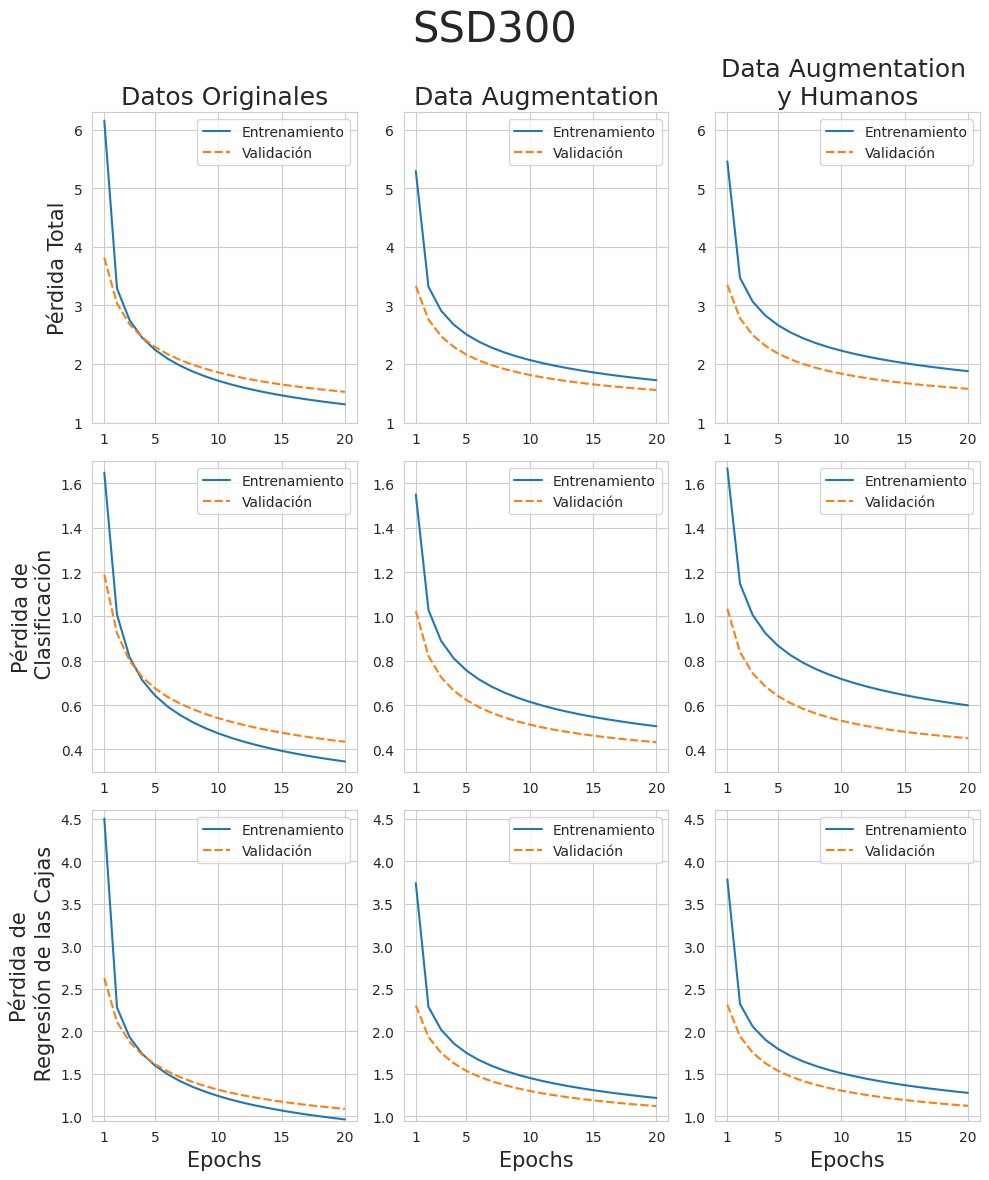

In [ ]:
with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(3, 3, figsize=(10, 12))

    # Datos Originales
    losses_plot = sns.lineplot(
        data = {
            "Entrenamiento": train_losses,
            "Validación": val_losses,
        },
        ax = axs[0, 0],
    )
    losses_plot.set_ylabel("Pérdida Total", fontsize=15)
    axs[0, 0].set_xticks([0, 4, 9, 14, 19])
    axs[0, 0].set_xticklabels([1, 5, 10, 15, 20])
    axs[0, 0].set_title("Datos Originales", fontsize=18)
    axs[0, 0].set_ylim([1, 6.3])

    classifier_losses_plot = sns.lineplot(
        data = {
            "Entrenamiento": train_losses_classifier,
            "Validación": val_losses_classifier,
        },
        ax = axs[1, 0],
    )
    classifier_losses_plot.set_ylabel("Pérdida de\n Clasificación", fontsize=15)
    axs[1, 0].set_xticks([0, 4, 9, 14, 19])
    axs[1, 0].set_xticklabels([1, 5, 10, 15, 20])
    axs[1, 0].set_ylim([0.3, 1.7])

    box_losses_plot = sns.lineplot(
        data = {
            "Entrenamiento": train_losses_box_reg,
            "Validación": val_losses_box_reg,
        },
        ax = axs[2, 0],
    )
    axs[2, 0].set_xticks([0, 4, 9, 14, 19])
    axs[2, 0].set_xticklabels([1, 5, 10, 15, 20])
    axs[2, 0].set_ylim([0.95, 4.6])
    box_losses_plot.set_ylabel("Pérdida de\n Regresión de las Cajas", fontsize=15)
    box_losses_plot.set_xlabel("Epochs", fontsize=15)

    # Data Augmentation
    augmented_losses_plot = sns.lineplot(
        data = {
            "Entrenamiento": augmented_train_losses,
            "Validación": augmented_val_losses,
        },
        ax = axs[0, 1],
    )
    axs[0, 1].set_xticks([0, 4, 9, 14, 19])
    axs[0, 1].set_xticklabels([1, 5, 10, 15, 20])
    axs[0, 1].set_title("Data Augmentation", fontsize=18)
    axs[0, 1].set_ylim([1, 6.3])

    augmented_classifier_losses_plot = sns.lineplot(
        data = {
            "Entrenamiento": augmented_train_losses_classifier,
            "Validación": augmented_val_losses_classifier,
        },
        ax = axs[1, 1],
    )
    axs[1, 1].set_xticks([0, 4, 9, 14, 19])
    axs[1, 1].set_xticklabels([1, 5, 10, 15, 20])
    axs[1, 1].set_ylim([0.3, 1.7])

    augmented_box_losses_plot = sns.lineplot(
        data = {
            "Entrenamiento": augmented_train_losses_box_reg,
            "Validación": augmented_val_losses_box_reg,
        },
        ax = axs[2, 1],
    )
    axs[2, 1].set_xticks([0, 4, 9, 14, 19])
    axs[2, 1].set_xticklabels([1, 5, 10, 15, 20])
    axs[2, 1].set_ylim([0.95, 4.6])
    augmented_box_losses_plot.set_xlabel("Epochs", fontsize=15)


    # Data Augmentation y Humanos
    augmented_humans_losses_plot = sns.lineplot(
        data = {
            "Entrenamiento": augmented_humans_train_losses,
            "Validación": augmented_humans_val_losses,
        },
        ax = axs[0, 2],
    )
    axs[0, 2].set_xticks([0, 4, 9, 14, 19])
    axs[0, 2].set_xticklabels([1, 5, 10, 15, 20])
    axs[0, 2].set_title("Data Augmentation \ny Humanos", fontsize=18)
    axs[0, 2].set_ylim([1, 6.3])

    augmented_humans_classifier_losses_plot = sns.lineplot(
        data = {
            "Entrenamiento": augmented_humans_train_losses_classifier,
            "Validación": augmented_humans_val_losses_classifier,
        },
        ax = axs[1, 2],
    )
    axs[1, 2].set_xticks([0, 4, 9, 14, 19])
    axs[1, 2].set_xticklabels([1, 5, 10, 15, 20])
    axs[1, 2].set_ylim([0.3, 1.7])

    augmented_humans_box_losses_plot = sns.lineplot(
        data = {
            "Entrenamiento": augmented_humans_train_losses_box_reg,
            "Validación": augmented_humans_val_losses_box_reg,
        },
        ax = axs[2, 2],
    )
    axs[2, 2].set_xticks([0, 4, 9, 14, 19])
    axs[2, 2].set_xticklabels([1, 5, 10, 15, 20])
    axs[2, 2].set_ylim([0.95, 4.6])
    augmented_humans_box_losses_plot.set_xlabel("Epochs", fontsize=15)

    fig.suptitle("SSD300", fontsize=30)
    plt.tight_layout()
    plt.show()